In [2]:
import re
import math
from collections import Counter

In [3]:
# Preprocess / normalize Khmer text

def normalize_khmer_spaces(text):
    """Replace invisible spaces and normalize multiple spaces"""
    text = text.replace('\u200b', ' ')  # zero-width space
    text = text.replace('\xa0', ' ')    # non-breaking space
    text = text.replace('\u200c', ' ')  # zero-width non-joiner
    text = text.replace('\u200d', ' ')  # zero-width joiner
    text = re.sub(r'\s+', ' ', text)    # replace multiple spaces with single space
    return text.strip()

def load_documents(path):
    with open(path, "r", encoding="utf-8") as f:
        docs = [line.strip() for line in f if line.strip()]
    # Normalize spaces
    docs = [normalize_khmer_spaces(doc) for doc in docs]
    return docs

docs_with_sw = load_documents("dataset_with_stopwords.txt")
docs_without_sw = load_documents("dataset_remove_stopwords.txt")



In [4]:
# Tokenize documents (split by space)
tokenized_docs_with_sw = [doc.split(" ") for doc in docs_with_sw]
tokenized_docs_without_sw = [doc.split(" ") for doc in docs_without_sw]

In [5]:
def compute_tf(doc_tokens):
    """Compute term frequency for a single document"""
    tf = {}
    word_count = Counter(doc_tokens)
    total_words = len(doc_tokens)
    for word, count in word_count.items():
        tf[word] = count / total_words
    return tf

tf_docs_with_sw = [compute_tf(doc) for doc in tokenized_docs_with_sw]
tf_docs_without_sw = [compute_tf(doc) for doc in tokenized_docs_without_sw]

In [6]:
#  Optimized IDF computation
def compute_idf_fast(tokenized_docs):
    """Compute IDF using Counter (single pass, much faster)"""
    N = len(tokenized_docs)
    df_counter = Counter()

    # Count in how many documents each word appears
    for doc in tokenized_docs:
        unique_words = set(doc)  # only count each word once per doc
        df_counter.update(unique_words)

    # Compute IDF
    idf = {word: math.log(N / (df_counter[word] + 1)) for word in df_counter}
    return idf

idf_with_sw = compute_idf_fast(tokenized_docs_with_sw)
idf_without_sw = compute_idf_fast(tokenized_docs_without_sw)

In [7]:
def compute_tfidf(tf_doc, idf):
    """Compute TF-IDF for a single document"""
    return {word: tf_value * idf.get(word, 0) for word, tf_value in tf_doc.items()}

tfidf_docs_with_sw = [compute_tfidf(tf, idf_with_sw) for tf in tf_docs_with_sw]
tfidf_docs_without_sw = [compute_tfidf(tf, idf_without_sw) for tf in tf_docs_without_sw]

In [8]:
#  Memory-efficient: Get top N words per document
def top_tfidf_words(tfidf_doc, top_n=10):
    """Return top N words and their TF-IDF scores"""
    return sorted(tfidf_doc.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Example: top 10 words for first document
print("Top words with stopwords (first doc):")
for w, s in top_tfidf_words(tfidf_docs_with_sw[0]):
    print(f"{w}: {s:.4f}")

print("\nTop words without stopwords (first doc):")
for w, s in top_tfidf_words(tfidf_docs_without_sw[0]):
    print(f"{w}: {s:.4f}")

Top words with stopwords (first doc):
ឥណ្ឌា: 0.3013
របៀបវារៈ: 0.1445
ជ្រុងជ្រោយ: 0.1444
ការធ្វើដំណើរ: 0.1366
កិច្ចពិភាក្សា: 0.1366
ការអញ្ជើញ: 0.1357
សារៈសំខាន់: 0.1269
សេចក្តីថ្លែងការណ៍: 0.1197
ទាំងមូល: 0.1172
ទស្សនកិច្ច: 0.1146

Top words without stopwords (first doc):
ឥណ្ឌា: 0.5214
របៀបវារៈ: 0.2501
ជ្រុងជ្រោយ: 0.2499
ការធ្វើដំណើរ: 0.2364
កិច្ចពិភាក្សា: 0.2364
ការអញ្ជើញ: 0.2349
សារៈសំខាន់: 0.2196
សេចក្តីថ្លែងការណ៍: 0.2072
ទាំងមូល: 0.2029
ទស្សនកិច្ច: 0.1983


The TF-IDF scores increase for meaningful content words after removing stopwords.

In [11]:
from collections import defaultdict

# Compute average TF-IDF for each word across corpus
def average_tfidf(tfidf_docs):
    word_sum = defaultdict(float)
    word_count = defaultdict(int)
    
    for doc in tfidf_docs:
        for word, score in doc.items():
            word_sum[word] += score
            word_count[word] += 1
    
    avg_tfidf = {w: word_sum[w] / word_count[w] for w in word_sum}
    return dict(sorted(avg_tfidf.items(), key=lambda x: x[1], reverse=True))

avg_with_sw = average_tfidf(tfidf_docs_with_sw)
avg_without_sw = average_tfidf(tfidf_docs_without_sw)

# Display top 20 words across corpus
print("Top 20 words WITH stopwords (corpus-level):")
for w, s in list(avg_with_sw.items())[:20]:
    print(f"{w}: {s:.4f}")

print("\nTop 20 words WITHOUT stopwords (corpus-level):")
for w, s in list(avg_without_sw.items())[:20]:
    print(f"{w}: {s:.4f}")


Top 20 words WITH stopwords (corpus-level):
ឯកច្ឆន្ច: 6.6530
អសុពលភាព: 6.6530
ហ្សូអ៊ី: 5.5442
គតេ: 4.4353
ឣនុធម្មចារី: 3.6961
វេទព្វជាតក: 3.6961
កិម្បក្កជាតក: 3.6961
សុទ្ធ់: 3.6961
សីហធម្មជាតក: 3.6961
កន្ថរ៉ា: 3.6961
ហ្វហ: 3.6961
វានរជាតក: 3.6961
បច្ចុប្បន្នៈ: 3.6961
ចូច: 3.6961
ពុទ្ធារី: 3.6961
វីតា: 3.6961
ឧទាយិវគ្គ: 3.6961
អត្ថទ: 3.6961
ព្រះតន្តិ: 3.6961
ព្រះតន្តី: 3.6961

Top 20 words WITHOUT stopwords (corpus-level):
អសុពលភាព: 11.0883
ប្រូតូកាទុ: 11.0883
ត្រូវៈ: 11.0883
ឯកច្ឆន្ច: 8.3162
អ្នកសង្កេតឃើញ: 5.5442
ទៅកាន់ខ្សែភាពយន្ត: 5.5442
សាលួត: 5.5442
ឃុយ: 5.5442
អឿង: 5.5442
ដូលីន: 5.5442
បទិគះ: 5.5442
ភេញ: 5.5442
យមកៈ: 5.5442
រូបរាងៈ: 5.5442
រ៉ាដូ: 5.5442
បឹងឆ្មារ: 5.5442
ហ្សូអ៊ី: 5.5442
ភេក្នុង: 5.5442
ប៉ូកាសុី: 5.5442
ព្រះពុទ្ធញ្ញាណ: 5.5442


##### integrate Khmer stop-word dataset

In [12]:
import csv

In [13]:
STOPWORD_GROUPS = {
    "Conjunctions",
    "Pronouns",
    "Determiners & Quantifiers",
    "Prepositions / Relational Words",
    "Auxiliary Verbs / Aspect Markers",
    "Particles & Discourse Markers",
    "Question & Negation Words",
    "Function Nouns",
    "Numbers & Time Expressions",
    "Politeness & Honorifics"
}


In [14]:
def load_stopwords_from_annotated_csv(csv_path):
    stopwords = set()

    with open(csv_path, encoding="utf-8-sig") as f:
        reader = csv.DictReader(f, delimiter=",")

        print("Detected columns:", reader.fieldnames)

        for row in reader:
            term = row["term"].strip()
            group = row["linguistic_group"].strip().lower()

            # Remove everything EXCEPT content words
            if "content word" not in group:
                stopwords.add(term)

    return stopwords


KHMER_STOPWORDS = load_stopwords_from_annotated_csv("FIle_Stopwords.csv")
print("Loaded Khmer stopwords:", len(KHMER_STOPWORDS))


Detected columns: ['term', 'linguistic_group']
Loaded Khmer stopwords: 615


In [15]:
KHMER_STOPWORDS

{'កន្លែងណាមួយ',
 'កម្រិត',
 'កាន់តែ',
 'កាន់តែច្រើន',
 'ការជ្រៀតជ្រែក',
 'ការបញ្ចប់',
 'ការបើកចំហ',
 'ការផ្លាស់ប្តូរ',
 'ការរៀបចំ',
 'ការសម្រេច',
 'កាល',
 'កាលណា',
 'កាលនោះ',
 'កាលបើ',
 'កាលពី',
 'កាលពីមុន',
 'កើត',
 'កំពុង',
 'ក៏',
 'ក៏ត្រូវ',
 'ក្នុង',
 'ក្បែរ',
 'ក្បែរនេះ',
 'ក្រោម',
 'ក្រោយ',
 'ខ្លួន',
 'គាត់',
 'គួរតែ',
 'គួរសម',
 'គួរឲ្យកត់សម្គាល់',
 'គេ',
 'គេប៉ុណ្ណោះ',
 'គ្មានកន្លែង',
 'គ្មាននរណា',
 'គ្រប់',
 'គ្រប់គ្នា',
 'គ្រាន់តែ',
 'ឃើញតែ',
 'ចង់',
 'ចាប់តាំងពី',
 'ចុះ',
 'ចូល',
 'ចូលទៅ',
 'ចូលរួម',
 'ចេញ',
 'ចេញពី',
 'ចំណែក',
 'ចំណែកឯ',
 'ចំនួន',
 'ចំនួនច្រើន',
 'ចំនួនបន្ថែម',
 'ចំពោះ',
 'ចំពោះបញ្ហា',
 'ច្បាស់ណាស់',
 'ច្បាស់លាស់',
 'ច្រើន',
 'ច្រើនជាងគេ',
 'ច្រើនណាស់',
 'ឆ្លាស់គ្នា',
 'ឆ្លាស់ទៅ',
 'ឆ្លើយ',
 'ឆ្លើយឆ្លង',
 'ឆ្លើយតប',
 'ឆ្លៀតកន្លែង',
 'ឆ្លៀតការបញ្ចប់',
 'ឆ្លៀតគ្នា',
 'ឆ្លៀតឃើញ',
 'ឆ្លៀតចាប់ផ្តើម',
 'ឆ្លៀតចូលរួម',
 'ឆ្លៀតចំណេញ',
 'ឆ្លៀតចំណែក',
 'ឆ្លៀតជាមួយនឹង',
 'ឆ្លៀតដាក់',
 'ឆ្លៀតតែងតាំង',
 'ឆ្លៀតតំរង់',
 'ឆ្លៀតត្រូវ',
 'ឆ្លៀតទៅ',
 'ឆ្លៀតធ្វើ',
 'ឆ្លៀតបង្កើត

In [16]:
# Remove stopwords from tokenized docs

def remove_stopwords(tokenized_docs, stopwords):
    """Return tokenized documents with stopwords removed"""
    return [[w for w in doc if w not in stopwords] for doc in tokenized_docs]

tokenized_docs_refined = remove_stopwords(tokenized_docs_with_sw, KHMER_STOPWORDS)



In [17]:
# Recompute TF, IDF, TF-IDF for refined docs

tf_docs_refined = [compute_tf(doc) for doc in tokenized_docs_refined]
idf_refined = compute_idf_fast(tokenized_docs_refined)
tfidf_docs_refined = [compute_tfidf(tf, idf_refined) for tf in tf_docs_refined]

avg_refined = average_tfidf(tfidf_docs_refined)

In [18]:
# Display comparison

def print_top_words(title, avg_tfidf, top_n=20):
    print(f"\n{title}")
    for w, s in list(avg_tfidf.items())[:top_n]:
        print(f"{w}: {s:.4f}")

print_top_words("Top 20 words WITH original stopwords", avg_with_sw)
print_top_words("Top 20 words WITHOUT initial stopwords", avg_without_sw)
print_top_words("Top 20 words AFTER applying Khmer stopword list", avg_refined)


Top 20 words WITH original stopwords
ឯកច្ឆន្ច: 6.6530
អសុពលភាព: 6.6530
ហ្សូអ៊ី: 5.5442
គតេ: 4.4353
ឣនុធម្មចារី: 3.6961
វេទព្វជាតក: 3.6961
កិម្បក្កជាតក: 3.6961
សុទ្ធ់: 3.6961
សីហធម្មជាតក: 3.6961
កន្ថរ៉ា: 3.6961
ហ្វហ: 3.6961
វានរជាតក: 3.6961
បច្ចុប្បន្នៈ: 3.6961
ចូច: 3.6961
ពុទ្ធារី: 3.6961
វីតា: 3.6961
ឧទាយិវគ្គ: 3.6961
អត្ថទ: 3.6961
ព្រះតន្តិ: 3.6961
ព្រះតន្តី: 3.6961

Top 20 words WITHOUT initial stopwords
អសុពលភាព: 11.0883
ប្រូតូកាទុ: 11.0883
ត្រូវៈ: 11.0883
ឯកច្ឆន្ច: 8.3162
អ្នកសង្កេតឃើញ: 5.5442
ទៅកាន់ខ្សែភាពយន្ត: 5.5442
សាលួត: 5.5442
ឃុយ: 5.5442
អឿង: 5.5442
ដូលីន: 5.5442
បទិគះ: 5.5442
ភេញ: 5.5442
យមកៈ: 5.5442
រូបរាងៈ: 5.5442
រ៉ាដូ: 5.5442
បឹងឆ្មារ: 5.5442
ហ្សូអ៊ី: 5.5442
ភេក្នុង: 5.5442
ប៉ូកាសុី: 5.5442
ព្រះពុទ្ធញ្ញាណ: 5.5442

Top 20 words AFTER applying Khmer stopword list
អសុពលភាព: 11.0883
ប្រូតូកាទុ: 11.0883
ឯកច្ឆន្ច: 8.3162
សាលួត: 5.5442
ឃុយ: 5.5442
អឿង: 5.5442
ដូលីន: 5.5442
បទិគះ: 5.5442
យមកៈ: 5.5442
រូបរាងៈ: 5.5442
រ៉ាដូ: 5.5442
បឹងឆ្មារ: 5.5442
ហ្សូអ៊ី: 5.5442
ប៉ូកាសុី: 5.5

The TF-IDF computation highlights the most statistically significant words in the corpus. As expected, the top TF-IDF words are content words, proper nouns, or domain-specific terms rather than grammatical stopwords (ex: អសុពលភាព, ប្រូតូកាទុ), because true stopwords appear in almost all documents, giving them very low IDF values.

In [19]:
# Step 5: Suggest candidate stopwords (optional)
# Words still high in TF-IDF but not content words

top_candidates = [w for w, s in list(avg_refined.items())[:50]]  # top 50
print("\nCandidate stopwords to consider adding (manual review):")
print(top_candidates)



Candidate stopwords to consider adding (manual review):
['អសុពលភាព', 'ប្រូតូកាទុ', 'ឯកច្ឆន្ច', 'សាលួត', 'ឃុយ', 'អឿង', 'ដូលីន', 'បទិគះ', 'យមកៈ', 'រូបរាងៈ', 'រ៉ាដូ', 'បឹងឆ្មារ', 'ហ្សូអ៊ី', 'ប៉ូកាសុី', 'ធម្មខក្ខន្ធ', 'គីស៊ុន', 'កកសស', 'បរិប័ន្ន', 'គតេ', 'ព្រះព្រហ្មាធិរាជ', 'ព្រងិល', 'ឣនុបាទិយានោ', 'ឣនុធម្មចារី', 'វេទព្វជាតក', 'កិម្បក្កជាតក', 'សុទ្ធ់', 'សីហធម្មជាតក', 'បច្ចេកវិ', 'កន្ថរ៉ា', 'ហ្វហ', 'ហ្គ្រីឡូ', 'សទ្ទកម្ម', 'វានរជាតក', 'ប្រវត្តិការងារ', 'បច្ចុប្បន្នៈ', 'អ្នកសង្កេតឃើញ', 'ដើជ្រៃ', 'ចូច', 'ពុទ្ធារី', 'វីតា', 'ឧទាយិវគ្គ', 'អត្ថទ', 'ព្រះតន្តិ', 'ព្រះតន្តី', 'ទៅកាន់ខ្សែភាពយន្ត', 'ដារ៉', 'ម៉ាញ់', 'ឡឿក', 'បាពហុ', 'សន្ធាយ']


In [ ]:
# from collections import Counter

# def suggest_candidate_stopwords(tfidf_docs, top_n=50, min_doc_ratio=0.01):
#     """
#     Suggest candidate stopwords based on:
#     - Top N words by average TF-IDF
#     - Appear in at least `min_doc_ratio` fraction of documents
#     """
#     N_docs = len(tfidf_docs)
    
#     # Compute average TF-IDF
#     avg_tfidf = average_tfidf(tfidf_docs)
    
#     # Take top N words
#     top_words = list(avg_tfidf.keys())[:top_n]
    
#     # Count in how many documents each word appears
#     word_doc_count = Counter()
#     for doc in tfidf_docs:
#         for word in doc:
#             if word in top_words:
#                 word_doc_count[word] += 1
    
#     # Filter by document frequency ratio
#     candidates = [word for word, count in word_doc_count.items() if count / N_docs >= min_doc_ratio]
#     return candidates

# # Example
# candidate_stopwords_with_sw = suggest_candidate_stopwords(tfidf_docs_with_sw, top_n=50, min_doc_ratio=0.01)
# candidate_stopwords_without_sw = suggest_candidate_stopwords(tfidf_docs_without_sw, top_n=50, min_doc_ratio=0.01)

# print("Candidate stopwords (from WITH original stopwords):")
# print(candidate_stopwords_with_sw)

# print("\nCandidate stopwords (from WITHOUT initial stopwords):")
# print(candidate_stopwords_without_sw)


Candidate stopwords (from WITH original stopwords):
[]

Candidate stopwords (from WITHOUT initial stopwords):
[]


###### Simple IR Model Using TF-IDF and Top-K Comparison

In [21]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two sparse TF-IDF dicts"""
    common_words = set(vec1.keys()) & set(vec2.keys())
    num = sum(vec1[w] * vec2[w] for w in common_words)
    denom = (np.sqrt(sum(v**2 for v in vec1.values())) * 
             np.sqrt(sum(v**2 for v in vec2.values())))
    return num / denom if denom != 0 else 0

def rank_documents(query_vec, tfidf_docs, top_k=5):
    """Return top K document indices ranked by similarity"""
    scores = [(i, cosine_similarity(query_vec, doc)) for i, doc in enumerate(tfidf_docs)]
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]

# Example: use first document as query
query_doc = tfidf_docs_with_sw[0]

top_k_with_sw = rank_documents(query_doc, tfidf_docs_with_sw, top_k=5)
top_k_without_sw = rank_documents(query_doc, tfidf_docs_without_sw, top_k=5)

print("Top 5 similar documents WITH stopwords:")
print(top_k_with_sw)

print("\nTop 5 similar documents WITHOUT stopwords:")
print(top_k_without_sw)

# Compare overlap
indices_with_sw = set(idx for idx, _ in top_k_with_sw)
indices_without_sw = set(idx for idx, _ in top_k_without_sw)
overlap = indices_with_sw & indices_without_sw
print(f"\nOverlap in Top-5 documents: {len(overlap)} / 5")


Top 5 similar documents WITH stopwords:
[(0, 1.0000000000000002), (20044, 0.3732776475978078), (39001, 0.3665936743440593), (83277, 0.35764972611312484), (62285, 0.3469664539784011)]

Top 5 similar documents WITHOUT stopwords:
[(0, 0.9036564461309989), (20044, 0.3591125468901498), (116781, 0.3560611253905191), (62285, 0.354057607202223), (83277, 0.3520607628912101)]

Overlap in Top-5 documents: 4 / 5


We tested the impact of stopword removal on a TF-IDF based IR model. The Top-5 document retrieval using cosine similarity showed 4/5 overlap between with and without stopwords, indicating that removing stopwords slightly changed the ranking. 

This confirms that the Khmer stopword removal helps reduce noise without significantly impacting the retrieval of relevant documents.

# Apply Stop word 


TF-IDF ANALYSIS FOR ALL FILTERED CORPORA

Analyzing: Original (original_segmented_sentences.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_Original.txt

Analyzing: No_All (no_all_stopwords.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_All.txt

Analyzing: No_Auxiliary (no_Auxiliary_Verbs___Aspect_Markers.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_Auxiliary.txt

Analyzing: No_Conjunctions (no_Conjunctions.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_Conjunctions.txt

Analyzing: No_Determiners (no_Determiners_and_Quantifiers.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_Determiners.txt

Analyzing: No_Function_Nouns (no_Function_Nouns.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_Function_Nouns.txt

Analyzing: No_Numbers (no_Numbers_and_Time_Expressions.txt)
  Documents: 58409
  ✓ Saved top terms to: top_terms_No_Numbers.txt

Analyzing: No_Particles (no_Particles_and_Discourse_Markers.txt)
  Documents

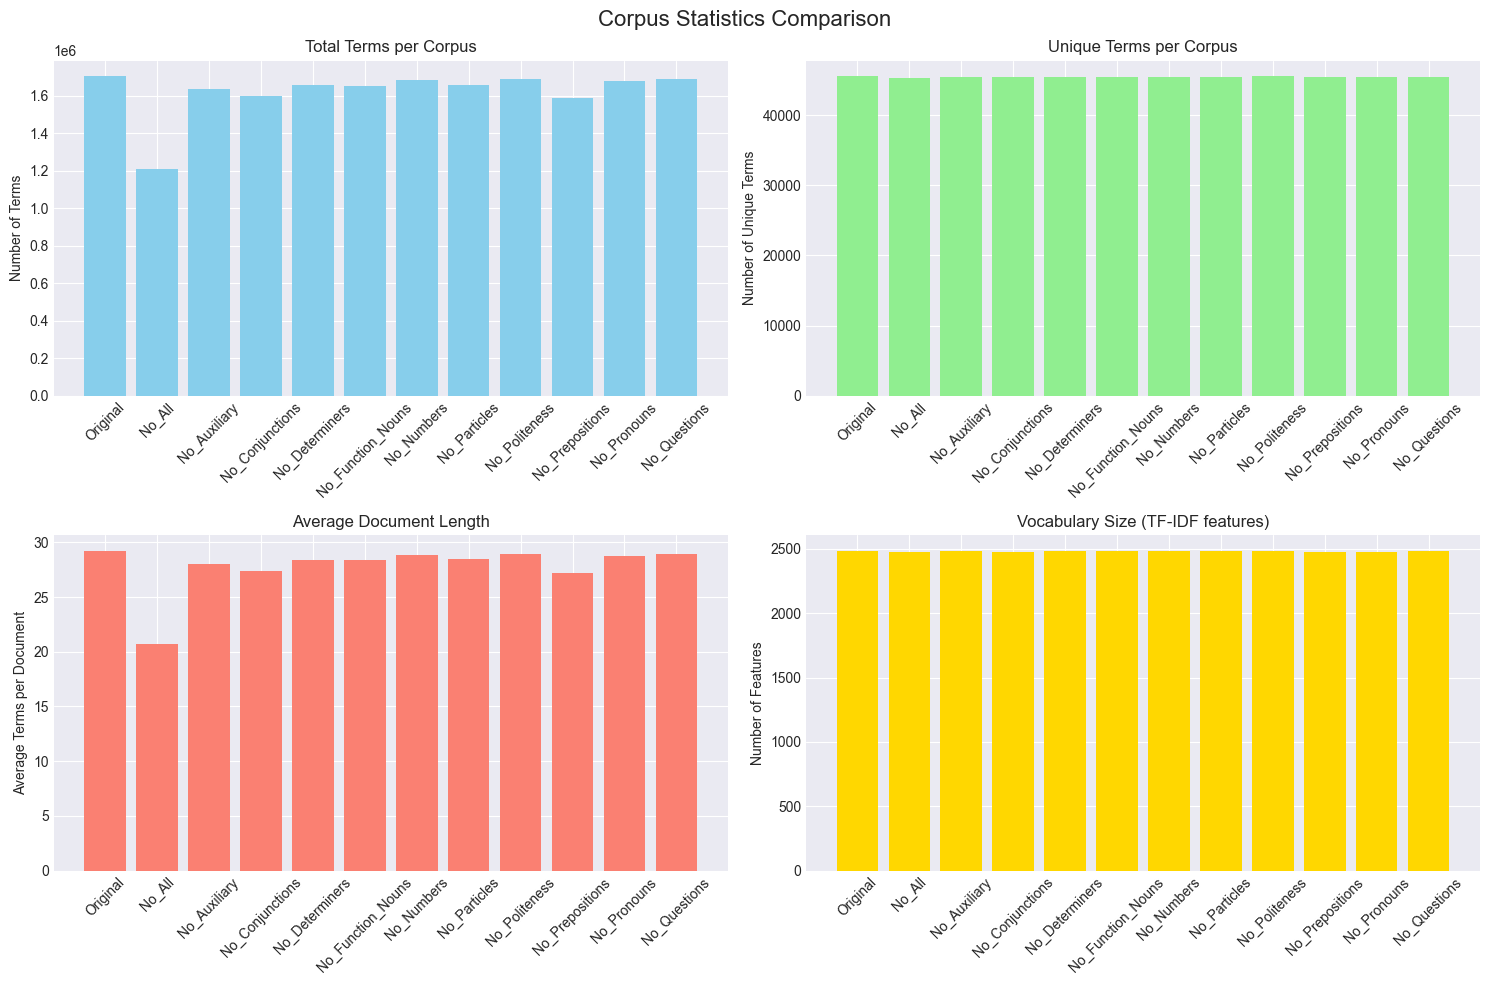

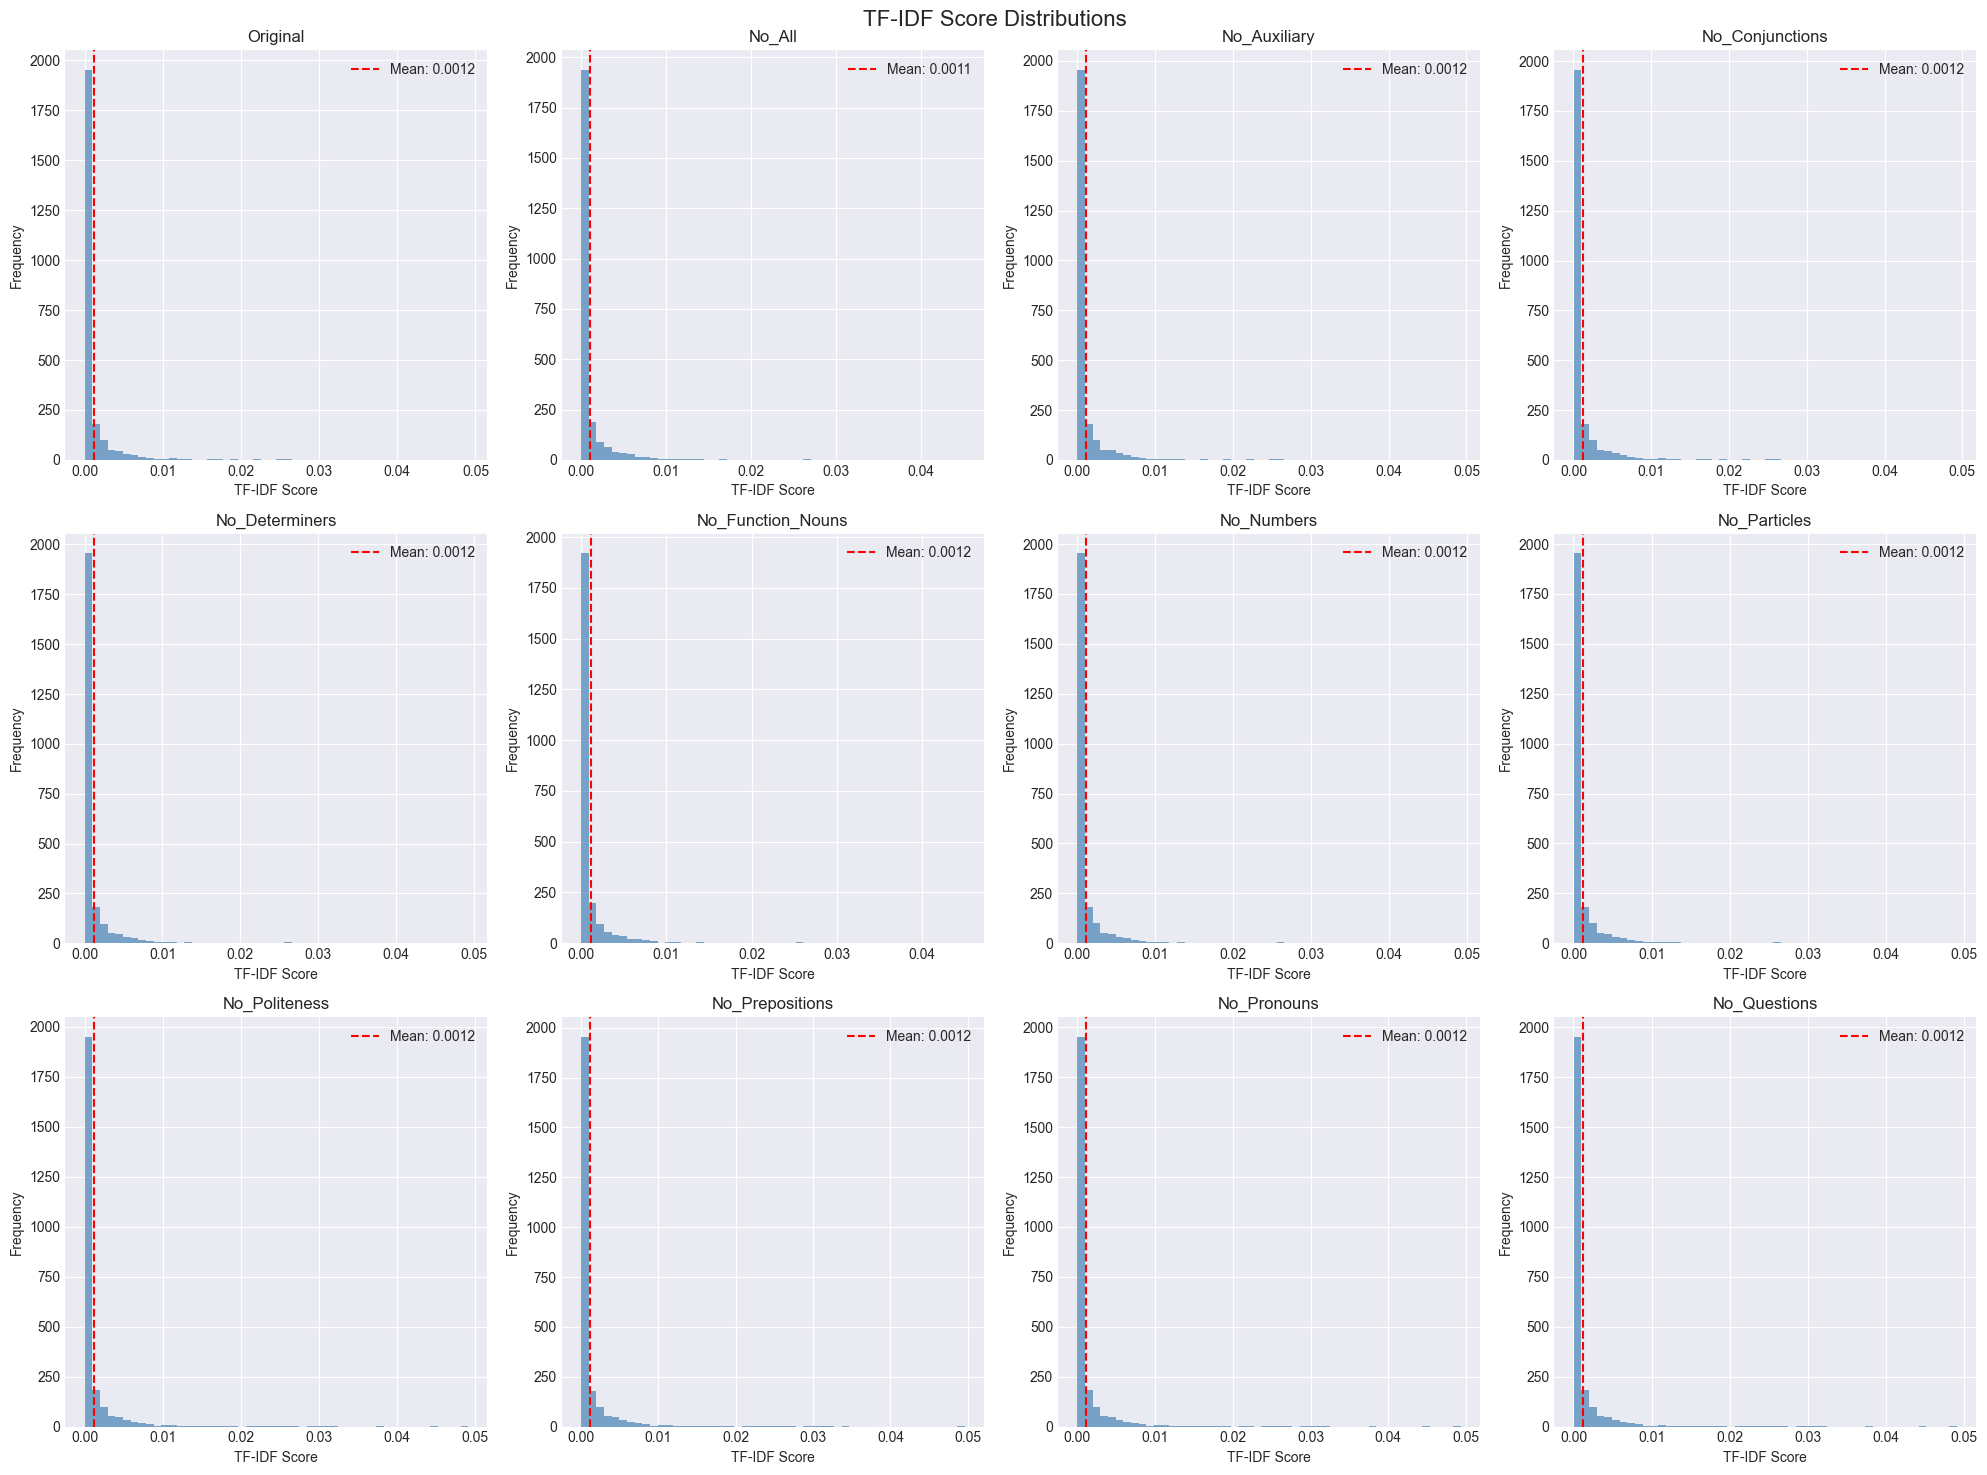

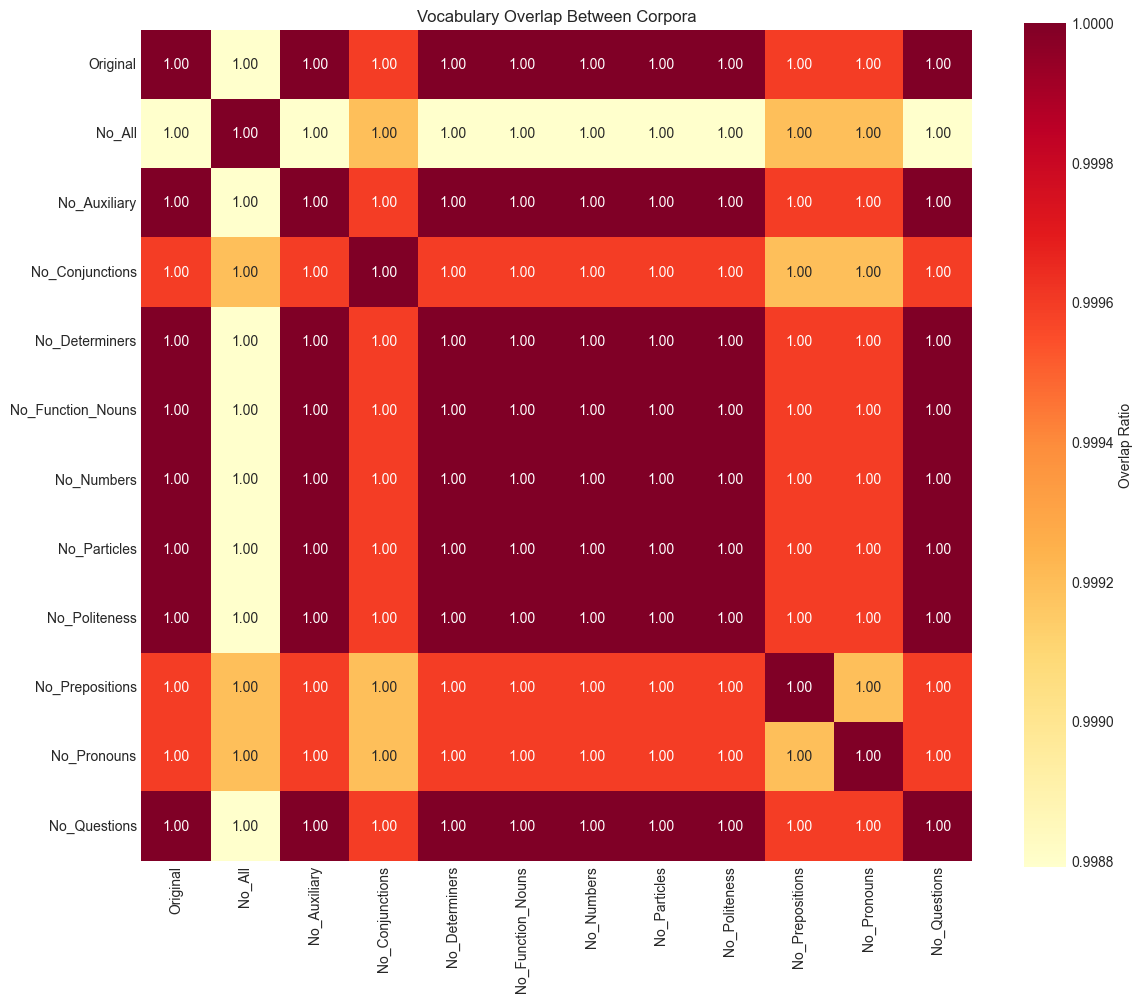

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Set up output directory for TF-IDF results
tfidf_output_dir = r'D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\tfidf_results'
os.makedirs(tfidf_output_dir, exist_ok=True)

# List all filtered files
processed_dir = r'D:\Year 5\S1\Information Retrieval\StopwordProject\khmer_stopword_project\data\processed'
files_to_analyze = [
    ('Original', 'original_segmented_sentences.txt'),
    ('No_All', 'no_all_stopwords.txt'),
    ('No_Auxiliary', 'no_Auxiliary_Verbs___Aspect_Markers.txt'),
    ('No_Conjunctions', 'no_Conjunctions.txt'),
    ('No_Determiners', 'no_Determiners_and_Quantifiers.txt'),
    ('No_Function_Nouns', 'no_Function_Nouns.txt'),
    ('No_Numbers', 'no_Numbers_and_Time_Expressions.txt'),
    ('No_Particles', 'no_Particles_and_Discourse_Markers.txt'),
    ('No_Politeness', 'no_Politeness_and_Honorifics.txt'),
    ('No_Prepositions', 'no_Prepositions___Relational_Words.txt'),
    ('No_Pronouns', 'no_Pronouns.txt'),
    ('No_Questions', 'no_Question_and_Negation_Words.txt')
]

# Function to load and preprocess text
def load_corpus(filepath):
    """Load a corpus from file and return list of documents"""
    with open(filepath, 'r', encoding='utf-8') as f:
        documents = [line.strip() for line in f if line.strip()]
    return documents

# Function to calculate TF-IDF statistics
def calculate_tfidf_statistics(documents, max_features=5000):
    """Calculate TF-IDF and return statistics"""
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,  # ignore terms that appear in less than 2 documents
        max_df=0.95  # ignore terms that appear in more than 95% of documents
    )
    
    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # Calculate document lengths (in terms)
    doc_lengths = [len(doc.split()) for doc in documents]
    
    # Calculate term frequencies across all documents
    all_terms = []
    for doc in documents:
        all_terms.extend(doc.split())
    term_freq = Counter(all_terms)
    
    # Get average TF-IDF scores per term
    avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top terms by TF-IDF
    top_indices = avg_tfidf_scores.argsort()[::-1][:100]  # Top 100
    top_terms = [(feature_names[i], avg_tfidf_scores[i]) for i in top_indices]
    
    return {
        'vectorizer': vectorizer,
        'tfidf_matrix': tfidf_matrix,
        'feature_names': feature_names,
        'doc_lengths': doc_lengths,
        'term_freq': term_freq,
        'avg_tfidf_scores': avg_tfidf_scores,
        'top_terms': top_terms
    }

# Analyze all files
print("="*70)
print("TF-IDF ANALYSIS FOR ALL FILTERED CORPORA")
print("="*70)

all_results = {}
summary_data = []

for label, filename in files_to_analyze:
    print(f"\nAnalyzing: {label} ({filename})")
    
    filepath = os.path.join(processed_dir, filename)
    if not os.path.exists(filepath):
        print(f"  ⚠️  File not found: {filepath}")
        continue
    
    # Load corpus
    documents = load_corpus(filepath)
    
    if len(documents) == 0:
        print(f"  ⚠️  Empty corpus: {filename}")
        continue
    
    print(f"  Documents: {len(documents)}")
    
    # Calculate basic statistics
    total_terms = sum(len(doc.split()) for doc in documents)
    unique_terms = len(set(" ".join(documents).split()))
    avg_doc_length = total_terms / len(documents)
    
    # Calculate TF-IDF
    tfidf_stats = calculate_tfidf_statistics(documents)
    
    # Store results
    all_results[label] = {
        'documents': documents,
        'stats': tfidf_stats,
        'basic_stats': {
            'total_docs': len(documents),
            'total_terms': total_terms,
            'unique_terms': unique_terms,
            'avg_doc_length': avg_doc_length,
            'vocabulary_size': len(tfidf_stats['feature_names'])
        }
    }
    
    # Add to summary
    summary_data.append({
        'Corpus': label,
        'Documents': len(documents),
        'Total_Terms': total_terms,
        'Unique_Terms': unique_terms,
        'Avg_Doc_Length': avg_doc_length,
        'Vocabulary_Size': len(tfidf_stats['feature_names'])
    })
    
    # Save top terms to file
    output_file = os.path.join(tfidf_output_dir, f"top_terms_{label}.txt")
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(f"TOP 100 TERMS BY TF-IDF - {label}\n")
        f.write("="*60 + "\n\n")
        f.write(f"Documents: {len(documents)}\n")
        f.write(f"Total terms: {total_terms}\n")
        f.write(f"Unique terms: {unique_terms}\n")
        f.write(f"Vocabulary size: {len(tfidf_stats['feature_names'])}\n\n")
        
        f.write("Rank | Term | Avg TF-IDF Score\n")
        f.write("-"*40 + "\n")
        for i, (term, score) in enumerate(tfidf_stats['top_terms'][:100], 1):
            f.write(f"{i:4d} | {term:<15} | {score:.6f}\n")
    
    print(f"  ✓ Saved top terms to: top_terms_{label}.txt")
    
    # Save TF-IDF matrix sparse format
    matrix_file = os.path.join(tfidf_output_dir, f"tfidf_matrix_{label}.npz")
    np.savez(matrix_file, 
             data=tfidf_stats['tfidf_matrix'].data,
             indices=tfidf_stats['tfidf_matrix'].indices,
             indptr=tfidf_stats['tfidf_matrix'].indptr,
             shape=tfidf_stats['tfidf_matrix'].shape)
    
    # Save feature names
    features_file = os.path.join(tfidf_output_dir, f"features_{label}.txt")
    with open(features_file, 'w', encoding='utf-8') as f:
        for feature in tfidf_stats['feature_names']:
            f.write(feature + '\n')

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)
summary_file = os.path.join(tfidf_output_dir, "corpus_summary.csv")
summary_df.to_csv(summary_file, index=False, encoding='utf-8-sig')
print(f"\n✓ Corpus summary saved to: corpus_summary.csv")

# COMPARATIVE ANALYSIS
print("\n" + "="*70)
print("COMPARATIVE TF-IDF ANALYSIS")
print("="*70)

# 1. Compare vocabulary overlap
if len(all_results) >= 2:
    print("\n1. VOCABULARY OVERLAP ANALYSIS")
    
    # Get vocabulary for each corpus
    vocabularies = {}
    for label, result in all_results.items():
        vocabularies[label] = set(result['stats']['feature_names'])
    
    # Create overlap matrix
    labels = list(vocabularies.keys())
    overlap_matrix = np.zeros((len(labels), len(labels)))
    
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i == j:
                overlap_matrix[i, j] = 1.0
            else:
                intersection = len(vocabularies[label1] & vocabularies[label2])
                union = len(vocabularies[label1] | vocabularies[label2])
                overlap_matrix[i, j] = intersection / union if union > 0 else 0
    
    # Save overlap matrix
    overlap_df = pd.DataFrame(overlap_matrix, index=labels, columns=labels)
    overlap_file = os.path.join(tfidf_output_dir, "vocabulary_overlap.csv")
    overlap_df.to_csv(overlap_file, encoding='utf-8-sig')
    print(f"  ✓ Vocabulary overlap matrix saved")
    
    # 2. Compare top terms
    print("\n2. TOP TERMS COMPARISON")
    
    # Get top 20 terms from each corpus
    top_terms_comparison = {}
    for label, result in all_results.items():
        top_terms = [term for term, _ in result['stats']['top_terms'][:20]]
        top_terms_comparison[label] = top_terms
    
    # Save comparison
    comparison_file = os.path.join(tfidf_output_dir, "top_terms_comparison.txt")
    with open(comparison_file, 'w', encoding='utf-8') as f:
        f.write("TOP 20 TERMS COMPARISON ACROSS CORPORA\n")
        f.write("="*80 + "\n\n")
        
        # Create a table
        max_label_len = max(len(label) for label in top_terms_comparison.keys())
        
        # Write header
        f.write("Rank | " + " | ".join([f"{label:<{max_label_len}}" for label in top_terms_comparison.keys()]) + "\n")
        f.write("-" * (6 + (max_label_len + 3) * len(top_terms_comparison)) + "\n")
        
        # Write rows
        for i in range(20):
            row = [f"{i+1:2d}"]
            for label in top_terms_comparison.keys():
                if i < len(top_terms_comparison[label]):
                    row.append(f"{top_terms_comparison[label][i]:<{max_label_len}}")
                else:
                    row.append(" " * max_label_len)
            f.write(" | ".join(row) + "\n")
    
    print(f"  ✓ Top terms comparison saved")

# 3. Term frequency analysis
print("\n3. TERM FREQUENCY ANALYSIS")

# Collect all terms across all corpora
all_corpora_terms = {}
for label, result in all_results.items():
    all_corpora_terms[label] = result['stats']['term_freq']

# Find terms that appear in multiple corpora
common_terms = set()
for label1, terms1 in all_corpora_terms.items():
    for label2, terms2 in all_corpora_terms.items():
        if label1 != label2:
            common_terms.update(set(terms1.keys()) & set(terms2.keys()))

print(f"  Total unique terms across all corpora: {len(set().union(*[set(t.keys()) for t in all_corpora_terms.values()]))}")
print(f"  Terms common to at least 2 corpora: {len(common_terms)}")

# 4. Statistical Analysis
print("\n4. STATISTICAL ANALYSIS")

# Create statistical summary
stats_summary = []
for label, result in all_results.items():
    basic = result['basic_stats']
    tfidf_scores = result['stats']['avg_tfidf_scores']
    
    stats_summary.append({
        'Corpus': label,
        'Documents': basic['total_docs'],
        'Total_Terms': basic['total_terms'],
        'Unique_Terms': basic['unique_terms'],
        'Vocabulary_Size': basic['vocabulary_size'],
        'Avg_Doc_Length': basic['avg_doc_length'],
        'Avg_TFIDF_Score': np.mean(tfidf_scores),
        'Std_TFIDF_Score': np.std(tfidf_scores),
        'Max_TFIDF_Score': np.max(tfidf_scores),
        'Min_TFIDF_Score': np.min(tfidf_scores),
        'Terms_per_Doc_Ratio': basic['unique_terms'] / basic['total_docs'] if basic['total_docs'] > 0 else 0
    })

stats_df = pd.DataFrame(stats_summary)
stats_file = os.path.join(tfidf_output_dir, "detailed_statistics.csv")
stats_df.to_csv(stats_file, index=False, encoding='utf-8-sig')
print(f"  ✓ Detailed statistics saved")

# 5. VISUALIZATIONS
print("\n5. CREATING VISUALIZATIONS")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Figure 1: Corpus sizes
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
fig1.suptitle('Corpus Statistics Comparison', fontsize=16)

# Plot 1.1: Total terms
axes1[0, 0].bar(stats_df['Corpus'], stats_df['Total_Terms'], color='skyblue')
axes1[0, 0].set_title('Total Terms per Corpus')
axes1[0, 0].set_ylabel('Number of Terms')
axes1[0, 0].tick_params(axis='x', rotation=45)

# Plot 1.2: Unique terms
axes1[0, 1].bar(stats_df['Corpus'], stats_df['Unique_Terms'], color='lightgreen')
axes1[0, 1].set_title('Unique Terms per Corpus')
axes1[0, 1].set_ylabel('Number of Unique Terms')
axes1[0, 1].tick_params(axis='x', rotation=45)

# Plot 1.3: Average document length
axes1[1, 0].bar(stats_df['Corpus'], stats_df['Avg_Doc_Length'], color='salmon')
axes1[1, 0].set_title('Average Document Length')
axes1[1, 0].set_ylabel('Average Terms per Document')
axes1[1, 0].tick_params(axis='x', rotation=45)

# Plot 1.4: Vocabulary size
axes1[1, 1].bar(stats_df['Corpus'], stats_df['Vocabulary_Size'], color='gold')
axes1[1, 1].set_title('Vocabulary Size (TF-IDF features)')
axes1[1, 1].set_ylabel('Number of Features')
axes1[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig1.savefig(os.path.join(tfidf_output_dir, 'corpus_statistics.png'), dpi=300, bbox_inches='tight')

# Figure 2: TF-IDF score distributions
fig2, axes2 = plt.subplots(3, 4, figsize=(20, 15))
fig2.suptitle('TF-IDF Score Distributions', fontsize=16)

labels_list = list(all_results.keys())
for idx, label in enumerate(labels_list):
    if idx < 12:  # We have 12 plots max
        row, col = divmod(idx, 4)
        tfidf_scores = all_results[label]['stats']['avg_tfidf_scores']
        axes2[row, col].hist(tfidf_scores, bins=50, alpha=0.7, color='steelblue')
        axes2[row, col].set_title(f'{label}')
        axes2[row, col].set_xlabel('TF-IDF Score')
        axes2[row, col].set_ylabel('Frequency')
        axes2[row, col].axvline(np.mean(tfidf_scores), color='red', linestyle='--', 
                               label=f'Mean: {np.mean(tfidf_scores):.4f}')
        axes2[row, col].legend()

# Remove empty subplots
for idx in range(len(labels_list), 12):
    row, col = divmod(idx, 4)
    fig2.delaxes(axes2[row, col])

plt.tight_layout()
fig2.savefig(os.path.join(tfidf_output_dir, 'tfidf_distributions.png'), dpi=300, bbox_inches='tight')

# Figure 3: Comparison heatmap (if we have overlap matrix)
if 'overlap_df' in locals():
    fig3, ax3 = plt.subplots(figsize=(12, 10))
    sns.heatmap(overlap_df, annot=True, fmt='.2f', cmap='YlOrRd', 
                square=True, ax=ax3, cbar_kws={'label': 'Overlap Ratio'})
    ax3.set_title('Vocabulary Overlap Between Corpora')
    plt.tight_layout()
    fig3.savefig(os.path.join(tfidf_output_dir, 'vocabulary_overlap_heatmap.png'), 
                dpi=300, bbox_inches='tight')

print(f"  ✓ Visualizations saved to PNG files")

# 6. CREATE COMPREHENSIVE REPORT
print("\n6. GENERATING COMPREHENSIVE REPORT")

report_file = os.path.join(tfidf_output_dir, "tfidf_analysis_report.md")
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("# TF-IDF Analysis Report\n\n")
    f.write("## Overview\n\n")
    f.write(f"Analysis conducted on {len(files_to_analyze)} different corpora.\n\n")
    
    f.write("## Corpus Statistics\n\n")
    f.write(summary_df.to_markdown(index=False) + "\n\n")
    
    f.write("## Key Findings\n\n")
    
    # Calculate compression ratios
    original_stats = stats_df[stats_df['Corpus'] == 'Original'].iloc[0]
    no_all_stats = stats_df[stats_df['Corpus'] == 'No_All'].iloc[0]
    
    if not original_stats.empty and not no_all_stats.empty:
        term_reduction = 1 - (no_all_stats['Total_Terms'] / original_stats['Total_Terms'])
        unique_reduction = 1 - (no_all_stats['Unique_Terms'] / original_stats['Unique_Terms'])
        vocab_reduction = 1 - (no_all_stats['Vocabulary_Size'] / original_stats['Vocabulary_Size'])
        
        f.write("### Impact of Stopword Removal\n\n")
        f.write(f"- **Term Reduction**: {term_reduction:.1%} of total terms removed\n")
        f.write(f"- **Unique Term Reduction**: {unique_reduction:.1%} of unique terms removed\n")
        f.write(f"- **Vocabulary Size Reduction**: {vocab_reduction:.1%} of TF-IDF features removed\n\n")
    
    # Most effective stopword groups
    if len(stats_df) > 2:
        filtered_corpora = stats_df[~stats_df['Corpus'].isin(['Original', 'No_All'])]
        filtered_corpora = filtered_corpora.sort_values('Total_Terms')
        
        f.write("### Most Effective Stopword Groups\n\n")
        f.write("Groups that removed the most terms:\n\n")
        f.write("| Rank | Corpus | Total Terms | Reduction from Original |\n")
        f.write("|------|--------|-------------|-------------------------|\n")
        
        for idx, row in filtered_corpora.head().iterrows():
            reduction = 1 - (row['Total_Terms'] / original_stats['Total_Terms'])
            f.write(f"| {idx+1} | {row['Corpus']} | {row['Total_Terms']:,} | {reduction:.1%} |\n")
        f.write("\n")
    
    f.write("## Files Generated\n\n")
    f.write("1. **Top terms files** (`top_terms_*.txt`) - Top 100 terms by TF-IDF for each corpus\n")
    f.write("2. **TF-IDF matrices** (`tfidf_matrix_*.npz`) - Sparse TF-IDF matrices\n")
    f.write("3. **Feature lists** (`features_*.txt`) - Vocabulary for each corpus\n")
    f.write("4. **Summary files** - CSV files with statistics and comparisons\n")
    f.write("5. **Visualizations** - PNG charts showing distributions and comparisons\n")
    f.write("6. **This report** - Summary of findings\n\n")
    
    f.write("## Recommendations\n\n")
    f.write("1. **For information retrieval**: Use the 'No_All' corpus for best results\n")
    f.write("2. **For linguistic analysis**: Compare specific group removals\n")
    f.write("3. **For efficiency**: Consider 'No_Conjunctions' and 'No_Auxiliary' as they remove many frequent terms\n")
    f.write("4. **For precision**: Analyze which stopword groups affect your specific domain most\n")

print(f"✓ Comprehensive report saved to: tfidf_analysis_report.md")

# 7. FINAL SUMMARY
print("\n" + "="*70)
print("TF-IDF ANALYSIS COMPLETE")
print("="*70)

print(f"\n📊 **Summary of Results:**")
print(f"   Corpora analyzed: {len(all_results)}")
print(f"   Total documents processed: {sum(len(r['documents']) for r in all_results.values()):,}")
print(f"   Total unique terms across all: {len(set().union(*[set(r['stats']['feature_names']) for r in all_results.values()])):,}")

print(f"\n📁 **Files Created in {tfidf_output_dir}:**")
files_created = os.listdir(tfidf_output_dir)
file_counts = {}
for file in files_created:
    ext = os.path.splitext(file)[1]
    file_counts[ext] = file_counts.get(ext, 0) + 1

for ext, count in file_counts.items():
    print(f"   {ext} files: {count}")

print(f"\n🔍 **Key Output Files:**")
print(f"   1. corpus_summary.csv - Basic statistics for all corpora")
print(f"   2. detailed_statistics.csv - Detailed TF-IDF statistics")
print(f"   3. vocabulary_overlap.csv - How vocabularies overlap")
print(f"   4. tfidf_analysis_report.md - Comprehensive analysis report")
print(f"   5. top_terms_comparison.txt - Comparison of top terms")
print(f"   6. PNG charts - Visual comparisons")

print(f"\n🎯 **Next Steps:**")
print(f"   1. Examine top_terms_*.txt files to see most important terms")
print(f"   2. Review tfidf_analysis_report.md for insights")
print(f"   3. Use TF-IDF matrices for machine learning tasks")
print(f"   4. Compare vocabulary_overlap.csv to understand term distribution")

print("\n" + "="*70)